# HMM learning

Probabilistic Modelling and Reasoning 2021-2022. University of Edinburgh.

Authors: Shangmin Guo (s.guo@ed.ac.uk), Vaidotas Simkus, Michael Gutmann

In this notebook, we will implement an unsupervised learning method for a hidden Markov model (HMM).

The notebook is based on PMR lectures, whose slides you can find [here](https://www.inf.ed.ac.uk/teaching/courses/pmr/). 

In this notebook, as before, we work with a homogeneous HMM with discrete observed and hidden states with the necessary (conditional) probability distributions represented by (conditional) probability tables.


## Table of contents

* Introduction
* Parametrisation of discrete HMM
* Overview of the implementation
* Implementation
  * Expectation step (E-step)
  * Maximisation step (M-step)
  * Baum-Welch algorithm (E-M)


# Introduction

When we are learning a new language, we have to learn, among many other things, the grammar of the language as well as its vocabulary. In the `HMM basics` notebook, we have introduced latent sentence templates that we can use to construct sentences, e.g. Subject -> Verb -> Object. The latent sentence templates were given by a hidden Markov chain. We can think that this hidden Markov chain, i.e. the latent variables together with the transition distribution, corresponds to a simple model of the grammar of the language. In turn, proper use of the vocabulary means knowing when one can use a given word. We can think that the emission distribution corresponds to a simple model of the proper use of the vocabulary.

In a supervised setting, e.g. when learning a language from a textbook, we may have annotations of the hidden states together with the used words. For example
 - sentences: `['I like dogs', 'I really love cats']`;
 - annotations: `[[Subject, Verb, Object], [Subject, Adverb, Verb, Object]]`.
 
When we have observations on the hidden variables, the learning problem is simpler: we can use standard maximum likelihood estimation for discrete random variables as with directed acyclic graphs. We have seen that this corresponds to frequency counting of words and annotations, and their co-occurences. Hence, given data on the state of the hidden variables, we could simply count the frequency of 
1. the states $k$ of the first hidden variable $h_1$ as $a_k$, 
2. transitions from hidden state $k'$ to $k$ as $A_{k',k}$, and
3. emitting word $m$ from hidden state $k$ as $B_{m,k}$.

Counting would thus allow us to learn the parameters of the HMM.

But, what if we do not have such annotations? The languages that we speak emerged naturally through complex social interactions and not from a concrete set of hidden grammar rules. So is it possible for computers to learn the grammar and use of vocabulary automatically without supervision? Yes, with some limitations, it can be done using HMMs and unsupervised learning.

As explained in the lecture, we can iteratively learn the parameters of an HMM model solely from observed sentences via the Baum-Welch algorithm, which consists of two steps: 
1. *Expectation*-step (E-step), where the expected log-likelihood is computed on filled-in data using the current parameters of the model and the inference algorithms implemented in the previous notebooks,
2. *Maximisation*-step (M-step), where updated parameters are computed such that they maximise the expectation from the E-step.

Before we implement the Baum-Welch algorithm, we also have to represent the parametrisation of the HMM in terms of variables in computer code which we do next.

# Parametrisation of discrete HMM

Following the slides in the lecture and the example in the `HMM basics` notebook, we model the homogeneous discrete HMM model with the following three parameters:
1. `_initial_`: the distribution over initial hidden states, which is implemented as a vector with shape `(num_hiddens,)`. It corresponds to the vector $\mathbf{a}\in\mathbb{R}^K$ introduced in the lecture where $a_k=p(h_1=k;\mathbf{a})$.
2. `_transition_`: the transition probability between the hidden states, which is implemented as a matrix with shape `(num_hiddens, num_hiddens)`. It corresponds to the matrix $\mathbf{A}\in\mathbb{R}^{K\times K}$ introduced in the lecture. In this notebook, we follow the convention $A_{k',k}=p(h_i=k | h_{i-1}=k'; \mathbf{A})$ for ease of implementation, which is the *transpose* of the matrix in the slides.
3. `_emission_`: the emission probability from a hidden state to an observation, which is implemented as a matrix with shape `(num_observations, num_states)`. It corresponds to the vector $\mathbf{B}\in\mathbb{R}^{M\times K}$ introduced in the lecture where $B_{m,k}=p(v_i=m|h_i=k; \mathbf{B})$.

In this tutorial, all of the above parameters will be stored as tensors, i.e. `np.array`, and the dimensions will be given in the corresponding sections.

# Overview of the implementation

We implement the unsupervised learning algorithm in an object-oriented manner. We here define the 
`HMMOptimiser` class and provide an overview of its attributes and methods.

The *attributes* of this class are:
 1. `model`: the HMM model whose parameters we would like to fit. The `HMM` model class is implemented in [`hmm.py`](./hmm.py), which includes the inference operations implemented in the previous notebooks.
 2. `num_hiddens`: an integer that specifies the number of possible hidden states. Since we do not know the *real* number of hidden states in the unsupervised setting, this is a tunable hyper-parameter in the [Baum-Welch algorithm](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm).
 3. `num_observations`: an integer that specifies the number of possible observed states. To handle the situations where the test data may contain observed states that do not appear in the training data, we can set this number to more than all the observed states in the training data.

The *methods* of the  `HMMOptimiser` class are:
1. `__init__`: initialises the optimiser with the provided arguments.
2. `baum_welch`: implements the Baum-Welch algorithm, which iteratively invokes the following two methods to update the parameters:
    1. `_e_step`: implements the expectation step by using the `marginal` method from the `HMM` class.
    2. `_m_step`: implements the maximisation step.
    3. `_initial_params_`: initialises the parameters.
    4. `_stop_criterion_`: checks if the iterations should be stopped.

For more details of each method please read the comments provided in the `HMMOptimiser` class in [`optimiser.py`](./optimiser.py) that contains all the code in one file.

In the following sections we explain how to implement the above methods in order to learn the parameters of an HMM model from data.

## Imports

In [1]:
# Import the necessary packages first
import math
from typing import List, Tuple
import numpy as np
np.random.seed(1234)
from numpy.typing import ArrayLike
from hmm import HMM  # class from hmm.py, which implements the inference methods from the previous tutorials
import jdc  # used to dynamically define Python classes in multiple cells 

For more information about the usage of `jdc` package, you can refer to [https://alexhagen.github.io/jdc/](https://alexhagen.github.io/jdc/).

We now define the `HMMOptimiser` class and implement the E- and M-steps, as well as the other required methods below.

## Class definition

In [2]:
class HMMOptimiser(object):
    """
    Implements the Baum-Welch (EM) algorithm to learn the parameters of a discrete HMM model.

    Attributes:
        model:             an HMM model from hmm.py
        num_hiddens:       an integer indicating the number of possible hidden states
        num_observations:  an integer indicating the number of possible observed states
    """
    def __init__(self, 
                num_hiddens:int,
                num_observations:int) -> None:
        super().__init__()
        assert num_hiddens is not None and num_observations is not None
        self.model = None
        self.num_hiddens = num_hiddens
        self.num_observations = num_observations

# Implementation
## E-step

The E-step of the Baum-Welch algorithm computes the ***expected* complete-data log-likelihood** given the observed data $\mathcal{D}$ and the current parameter estimate $\theta_{\text{old}}$.
Although we do not have the complete data, we can **probabilistically fill-in the latents** using the HMM model with current parameters $\theta_{\text{old}}$.

For the discrete-valued HMM in this notebook, we compute the EM objective derived in the lecture, i.e. 

$$
\begin{aligned}
J(\theta, \theta_{\text{old}}) =
& \sum_{j=1}^{N} \sum_{k=1}^{K} p(h_1=k|\mathcal{D}_j; \theta_{\text{old}})\log a_k\\
&+ \sum_{j=1}^{N} \sum_{i=2}^{d_j} \sum_{k=1}^{K} \sum_{k'=1}^{K} p(h_i=k, h_{i-1}=k'|\mathcal{D}_j; \theta_{\text{old}})\log A_{k',k}\\
&+ \sum_{j=1}^{N} \sum_{i=1}^{d_j} \sum_{k=1}^{K} \sum_{m=1}^{M} \mathbb{I}(v_i^{(j)}=m)p(h_i=k|\mathcal{D}_j, \theta_{old})\log B_{m,k}
\end{aligned}
$$
where $N$ is the number of sequences, $K$ is the number of possible hidden states, $d_j$ is the length of the $j$-th sequence, $M$ is the number of observed states (e.g. words), and $\theta_{\text{old}} = (\log a_k, \log A_{k',k}, \log B_{m,k})$ are the current parameters.

To compute the above objective in the E-step we must know the following distributions:
 - $p(h_1|\mathcal{D}_j; \theta_{\text{old}})$,
 - $p(h_i, h_{i-1}|\mathcal{D}_j; \theta_{\text{old}})$,
 - $p(h_i|\mathcal{D}_j, \theta_{old})$.

You should recognise these quantities from the previous notebooks: the first and last are the quantities calculated in the inference notebook, i.e. $p(h_i \mid v_{1:d})$, and the second quantity is the joint marginal of neighbouring states $p(h_i, h_{i-1} \mid v_{1:d})$ that can be computed as 

$$
p(h_i, h_{i-1} \mid v_{1:d}) = \frac{\alpha_{i-1}(h_{i-1}) \beta_{i}(h_{i}) p(h_{i} \mid h_{i-1}) p(v_i \mid h_i)}{p(v_{1:d})}
$$

This shows that the learning algorithm is based on the inference methods discussed before.
The code that computes the required quantities using the forward-backward method is implemented in [`hmm.py`](hmm.py) as `marginal()` method in the `HMM` model class.

Look at the code in [`hmm.py`](hmm.py) of `marginal()` method to understand how the above quantities are computed.

In [3]:
%%add_to HMMOptimiser
def _e_step(self, data_loader:object) -> Tuple[float, List, List]:
    hk_list = []
    hkk_list = []
    log_ps = []
        
    for o_seq in data_loader:
        _, _, log_p, hk, hkk = self.model.marginal(o_seq)
            
        hk_list.append(hk)
        hkk_list.append(hkk)
        log_ps.append(log_p)
        
    return np.mean(log_ps), hk_list, hkk_list

Some useful information to understand the above code:
 1.  `hk_list` stores the values of $p(h_i = k| \mathcal{D}_j; \theta_{old}), \forall k\in[1,\dots,K], \forall i\in[1,\dots,d_j], \forall j\in[1,\dots, N]$; thus each element is an `np.array` with size [$d_j$, $K$].
 2.  `hkk_list` stores the values of $p(h_i=k, h_{i-1}=k' | D_j; \theta_{old}), \forall k,k'\in[1,\dots,K], \forall i\in[2,\dots,d_j], \ \forall j\in[1,\dots,N]$, thus each element is an `np.array` with size [$d_j$, $K$, $K$].

## M-step

The M-step of the Baum-Welch algorithm maximises the expected log-likelihood after filling-in the unobserved data. For the discrete-valued HMM parametrised using probability tables we can obtain the following closed-form solutions to the optimisation problem:
$$
\begin{aligned}
a_k & = \frac{1}{n}\sum_{j=1}^{n}p(h_1=k|\mathcal{D}_j;\theta_{\text{old}}); \\
A_{k', k} & = \frac{\sum_{j=1}^{n}\sum_{i=2}^{d_j}p(h_i=k,h_{i-1}=k'|\mathcal{D}_j;\theta_{\text{old}})}{\sum_k\sum_{j=1}^{n}\sum_{i=2}^{d_j}p(h_i=k,h_{i-1}=k'|\mathcal{D}_j;\theta_{\text{old}})} \\
B_{m,k} & = \frac{\sum_{j=1}^{n}\sum_{i=1}^{d_j}\mathbb{I}(v_i^{(j)}=m)p(h_i=k|\mathcal{D}_j;\theta_{\text{old}})}{\sum_{m}\sum_{j=1}^{n}\sum_{i=1}^{d_j}\mathbb{I}(v_i^{(j)}=m)p(h_i=k|\mathcal{D}_j;\theta_{\text{old}})}
\end{aligned}
$$

As you can see in the above equations, we enumerate through all the hidden/observed states in all sequences.
Thus, the above update bears similarity to the supervised learning case discussed above, i.e. it is similar to counting the frequency of 1) the first hidden state $h_1$, 2) transitioning from a hidden state $k'$ to state $k$, and 3) emitting symbol $m$ from hidden state $k$. However, crucially it uses the model with the current parameters to infer the probabilities over the unknown hidden states, rather than using known observations.

Read and complete the below code where there is a `# your code here` comment. We have also provided the code at the end of the method that normalises the distributions. 
Hence, your task is to make sure that the numerators in the above equations are computed correctly.

Hint 1: We have provided a loop that runs over the samples, corresponding to the sum $\sum_{j=1}^{n}$.  
Hint 2: Note also that the update to the `_emission_` matrix (or $\mathbf{B}$) has an indicator function which tells us to which row of the matrix we should add $p(h_i=k|\mathcal{D}_j;\theta_{\text{old}})$. 


In [4]:
%%add_to HMMOptimiser
def _m_step(self, 
            data_loader:object, 
            hk_list:List, 
            hkk_list:List
            ) -> Tuple[ArrayLike, ArrayLike, ArrayLike]:
    _initial_ = np.zeros(self.num_hiddens)
    _transition_ = np.zeros([self.num_hiddens, self.num_hiddens]) 
    _emission_ = np.zeros([self.num_observations, self.num_hiddens])
    
    for j, obs in enumerate(data_loader):
        # Retrieve the distributions inferred in the E-step for the current observation obs
        hk = hk_list[j]
        hkk = hkk_list[j]
        # Handle obs of length 1 for which hkk is None
        hkk = hkk if hkk is not None else float('-inf')*np.ones([1, self.num_hiddens, self.num_hiddens])

        _initial_ += ... # your code here
        _transition_ += ... # your code here
        for m, ob in enumerate(obs):
            _emission_[ob] += ... # your code here
            # hint: _emission_[ob] += np.exp(hk) would cause an error
    
    # Normalise the distributions
    _initial_ /= len(data_loader)
    _transition_ /= _transition_.sum(axis=1, keepdims=True)
    _emission_ /= _emission_.sum(axis=0, keepdims=True)
    
    return _initial_, _transition_, _emission_

## Other methods of the  Baum-Welch algorithm

We have discussed and implemented the two main iterative steps in the Baum-Welch algorithm. We must now also address the following essential implementation questions:

 1. *initialisation of parameters*: how should we initialise parameters, i.e. $\mathbf{a},\mathbf{A},\mathbf{B}$?
 2. *stop criterion*: when should we stop the iteration of E/M-steps?

### Initialisation of parameters

Given a set of parameters we can now perform the E- and M-steps. 
But what should the initial parameters be?

**Exercise.** Someone may initialise all (conditional) probability tables $\mathbf{a},\mathbf{A},$ and $\mathbf{B}$ with *constants* to represent uniform distributions. Can you identify a problem of the suggested initialisation method?  
*Hint*: first consider what would $p(h_i=k|\mathcal{D}_j;\theta_{\text{old}})$ and $p(h_i=k, h_{i-1}=k'|\mathcal{D}_j;\theta_{\text{old}})$ be with uniform $\mathbf{a}, \mathbf{A}$, and $\mathbf{B}$. Then, what would the matrices $\mathbf{a}, \mathbf{A}$, and $\mathbf{B}$ be like after the M-step?

In the following implementation, we instead initialise the parameters randomly from the uniform distribution on $[0, 1)$ and the normalise to obtain random initial (conditional) probability tables. 

In [5]:
%%add_to HMMOptimiser
def _initial_params(self) -> Tuple[ArrayLike, ArrayLike, ArrayLike]:
    initial = np.random.uniform(size=self.num_hiddens)
    initial /= initial.sum(axis=0)

    transition = np.random.uniform(size=[self.num_hiddens, self.num_hiddens])
    transition /= transition.sum(axis=1, keepdims=True)

    emission = np.random.uniform(size=[self.num_observations, self.num_hiddens])
    emission /= emission.sum(axis=0, keepdims=True)

    return initial, transition, emission

Answer to the above exercise:

Let us first consider the term $p(h_i=k|\mathcal{D}_j;\theta_{\text{old}})$, which can be computed using the alpha-beta recursion $p(h_i=k|\mathcal{D}_j;\theta_{\text{old}}) = \frac{1}{Z}\alpha_i(h_i = k)\beta_i(h_i = k)$.  
You should recall that 
$$
\alpha_i(h_i = k) = p(v_{1:i}, h_{i} = k) = \sum_{k'} \alpha_{i-1}(k')p(h_i = k \mid h_{i - 1} = k')p(v_i \mid h_i = k), \quad \text{with} \quad \alpha_1(h_1 = k) = p(h_1 = k)p(v_1 \mid h_1 = k)
$$ 
and 
$$\beta_i(h_i = k) = p(v_{i+1:T} \mid h_{i} = k) = \sum_{k'} \beta_{i+1}(k') p(h_{i+1} = k' \mid h_{i} = k) p(v_{i+1} \mid h_{i+1}=k'), \quad \text{with} \quad \beta_T(h_i = k) = 1.
$$

Now note that $\alpha_1(k)$ is a constant for all $k$ since both $p(h_1 = k) = a_k$ and $p(v_1 = m \mid h_1 = k) = B_{m, k}$ are constant for all $k$ and $m$. Similarly, by recursion $\alpha_i(k)$ for all $i$ are constant, since $p(h_i = k \mid h_{i - 1} = k') = A_{k', k}$ is constant for all $k$ and $k'$. The same argument applies to $\beta_i(k)$ for all $i$, which is constant for all $k$. Because $\alpha_i(k)$ and $\beta_i(k)$ are constant for all $k$, $p(h_i=k|\mathcal{D}_j;\theta_{\text{old}})$ is also a constant uniform distribution. 
A similar argument can be made to note that $p(h_i=k, h_{i-1}=k'|\mathcal{D}_j;\theta_{\text{old}})$ would also be constant for all $k$ and $k'$.


Given that all inferred distributions ($p(h_i=k|\mathcal{D}_j;\theta_{\text{old}})$ and $p(h_i=k, h_{i-1}=k'|\mathcal{D}_j;\theta_{\text{old}})$) would be uniform, looking at the update equations of $\mathbf{a}$ and $\mathbf{A}$ in the M-step you should note that the updated parameters $\mathbf{a}$ and $\mathbf{A}$ will remain uniform and no learning is happening. 
Moreover, because $p(h_i=k|\mathcal{D}_j;\theta_{\text{old}})$ is constant, these terms in the numerator and denominator of the update for $\mathbf{B}$ will cancel, and hence 
$$
B_{m,k} = \frac{\sum_{j=1}^{n}\sum_{i=1}^{d}\mathbb{I}(v_i^{(j)}=m)}{\sum_{m}\sum_{j=1}^{n}\sum_{i=1}^{d}\mathbb{I}(v_i^{(j)}=m)} = \frac{\text{# }m\text{ words in the dataset}}{\text{total # words in the dataset}}.
$$
In particular $\mathbf{B}_m$ vector is independent of the hidden states $k$, i.e. $B_{m, k} = B_{m, k'}$ for $\forall k, k'$. It hence corresponds to a Markov model of order 0.


### Stop criterion

Having implemented the parameter initialisation method and the E/M-steps above, we can now run the loop of the Baum-Welch algorithm.
However there is still one more remaining question: when should we stop iterating?

There are some heuristic criteria:
 1. *small change of parameters*: if a local maxima is reached, then the derivative of the parameters would be 0. Therefore, there should be no change of parameters in the M-step either, and hence we can stop the iterations.
 2. *small change of likelihood*: alternatively, we can stop the iteration if the change of (log-)likelihood of the model given the data becomes small. Note that the log-likelihood is available as a by-product from the computation of the marginal and joint of the latents that are needed in the E-step.
 3. *number of steps*: sometimes our initialisation might be particularly bad, then it may take a very long time for the learning to converge (in terms of the above criteria). To avoid excessive number of iterations we can set a maximum number of iterations and stop the loop immediately if the maximum number of iterations is exceeded.
 4. *mix*: in practice a mixture of the above criteria is most often used.
 
Below we ask you to fill in the code for the stopping criterion. The algorithm should stop when the maximum number of steps is exceeded, the change in parameters (`delta_param`) is less than $10^{-16}$, or the change in the log-likelihood (`delta_logpx`) is less than $10^{-8}$.

In [6]:
%%add_to HMMOptimiser
@staticmethod
def _stop_criterion(step:int=0, 
                    delta_param:float=1e-3,
                    delta_logpx:float=1e-1,
                    ) -> bool:
    max_steps = 100
    min_delta_param = 1e-16
    min_delta_logpx = 1e-8
    stop_condition = ... # your code here
    return stop_condition

### Main loop of the Baum-Welch algorithm

We now have all the steps of the Baum-Welch algorithm implemented. We must now run them in the following order:
 1. initialise the parameters of HMM;
 2. compute the E-step with the current parameters;
 3. update parameters with the M-step;
 4. continue back to Step 2 if the stop criterion is not met.

We add the following `baum_welch` method to our `HMMOptimiser` class below, which fits a given `HMM` model.

In [7]:
%%add_to HMMOptimiser
def baum_welch(self, data_loader:List[List[int]], verbose:bool=True):
    # Step 1: initialise the parameters for HMM model
    initial, transition, emission = self._initial_params()
    self.model = HMM(np.log(initial),
                     np.log(transition),
                     np.log(emission)
                     )
        
    # Step 2: set up the following variables for repeating the E/M-steps.
    stop = False                    # flag for stopping the loop
    step = 0                        # track the number of steps
    delta_param = math.inf          # track the change of parameters
    delta_loglikelihood = math.inf  # track the change of log-likelihood
    last_loglikelihood = 0.
    loglikelihood_list = []
        
    # Step 3: repeat the E/M-steps
    while not stop:
        # step 3.1: E-step
        loglikelihood, hk_list, hkk_list = self._e_step(data_loader)
        # step 3.2: M-step
        _initial_, _transition_, _emission_ = self._m_step(data_loader, hk_list, hkk_list)
        
        # step 3.3: track step and change of parameters/log-likelihoods
        step += 1
        delta_param = self.model.get_delta_param(
                                    np.log(_initial_),
                                    np.log(_transition_),
                                    np.log(_emission_)
                                )
        delta_loglikelihood = abs(loglikelihood - last_loglikelihood)
        last_loglikelihood = loglikelihood
        
        # step 3.4: update the parameters of HMM model
        self.model.initial = np.log(_initial_)
        self.model.transition = np.log(_transition_)
        self.model.emission = np.log(_emission_)
        
        #step 3.5: check if we should end the loop now
        stop = self._stop_criterion(step, delta_param, delta_loglikelihood)
        
        # monitor the learning procedure
        loglikelihood_list.append(loglikelihood)
        if verbose:
            print('step:', step, '\tloglikelihood:', loglikelihood)

    self._trained_ = True
    
    return loglikelihood_list

## Putting it all together

We have implemented all the necessary methods of the Baum-Welch and we can finally run it on some data.
We have provided a `DataLoader` class in [`data.py`](./data.py) to make it easy to load data or generate sequences following a hidden Markov structure.

Below, we the data loader to synthesise a dataset of 300 random sequences by specifying the `initial`, `transition`, and `emission` matrices and then optimise the parameters of an `HMM` on them. We will then inspect if the learnt parameters are *close* to the true ones.

In [8]:
# Step 1: specify the parameters for synthesising data
# there are 2 hidden states, and 3 possible observed states where observation
# `0` means the end of sequence (<EOS>).
initial = np.array([0.2, 0.8])
transition = np.array([[0.2, 0.8],
                       [0.6, 0.4]])
emission = np.array([[0.0, 0.1], # probability of emitting <EOS>
                     [0.3, 0.8],
                     [0.7, 0.1]])

# Step 2: synthesise sequences
from data import DataLoader
dataloader = DataLoader(initial=initial,
                        transition=transition,
                        emission=emission)

data_list = dataloader.get_data_list(300)

# Step 3: fit an HMM by using HMMOptimiser class
optim = HMMOptimiser(num_hiddens=2, num_observations=3)
_ = optim.baum_welch(data_list)
hmm = optim.model

# Step 4: print the parameters fit on the synthetic data
# Note that parameters of our HMM class are in the log space
print('true initial:\n', initial)
print('fitted initial:\n', np.exp(hmm.initial))
print('true transition:\n', transition)
print('fitted transition:\n', np.exp(hmm.transition))
print('true emission:\n', emission)
print('fitted emission:\n', np.exp(hmm.emission))

step: 1 	loglikelihood: -21.895014212780573
step: 2 	loglikelihood: -14.8788336784997
step: 3 	loglikelihood: -14.864822392003255
step: 4 	loglikelihood: -14.847695936904705
step: 5 	loglikelihood: -14.827609957838085
step: 6 	loglikelihood: -14.805280341531489
step: 7 	loglikelihood: -14.782025541506433
step: 8 	loglikelihood: -14.75956138238913
step: 9 	loglikelihood: -14.739557979334398
step: 10 	loglikelihood: -14.723157432754633
step: 11 	loglikelihood: -14.71071898233548
step: 12 	loglikelihood: -14.701903148530858
step: 13 	loglikelihood: -14.695975497374338
step: 14 	loglikelihood: -14.69212145375297
step: 15 	loglikelihood: -14.689642919292943
step: 16 	loglikelihood: -14.688025651724404
step: 17 	loglikelihood: -14.686926675589039
step: 18 	loglikelihood: -14.686132074940026
step: 19 	loglikelihood: -14.68551428049148
step: 20 	loglikelihood: -14.68499939436896
step: 21 	loglikelihood: -14.684545359061236
step: 22 	loglikelihood: -14.684128461633678
step: 23 	loglikelihood: -

Note that the HMM model is non-identifiable in general. Specifically, it means that you could permute the hidden state values $h$ and the corresponding matrices $\mathbf{a}, \mathbf{A}$, and $\mathbf{B}$ and obtain the same log-likelihood. As we see the hidden states in the learnt model above were permuted, i.e. the order of the values in the fitted parameters $\hat{\mathbf{a}}$ corresponds to a reversed order compared to the true parameter $\mathbf{a}$, and an equivalent permutation can also be seen in the fitted $\hat{\mathbf{A}}$ and $\hat{\mathbf{B}}$ matrices compared to the true ones $\mathbf{A}$ and $\mathbf{B}$.

### Tips on the sanity check of your implementation

Since the Baum-Welch algorithm can only guarantee that the model converges to a **local optima**, the learnt parameters might not be exactly the same to the true parameters used to synthesise data.
But, if the implementation is correct, we should be able to observe all of the following phenomena during learning:
 1. *Non-decreasing likelihood of data*: the (log-)likelihood of the sequences should never decrease during the iteration of E- and M-steps;
 2. *Variance of the learnt parameter distance to the true parameters decreases with more data*: the more observed sequences we have for learning, the smaller the variance of the distance between the learnt parameter values and the true values.
 3. *Parameters do not diverge if true parameters are used in initialisation*: if we use the true parameters to initialise the parameters of the `HMM`, the parameters should stay around the initial values during learning. Note that the true parameters might not be the optimal values for a particular dataset sample due to the finite sample size.

In the following cell we provide a function to verify the first two cases in the above list.

In [9]:
def get_true_params() -> Tuple[ArrayLike]:
    initial = np.array([0.2, 0.8])
    transition = np.array([[0.2, 0.8],
                           [0.6, 0.4]])
    emission = np.array([[0.0, 0.1], # probability of emitting <EOS>
                         [0.3, 0.8],
                         [0.7, 0.1]])
    return initial, transition, emission

def get_dist_to_true_params(params:Tuple[ArrayLike], 
                            true_params:Tuple[ArrayLike]) -> float: 
    # Compute the Euclidean distance (L2 norm) between the learnt parameters and the true parameters
    
    # To handle the non-identifiability of the HMM, for the 2D hiddens case
    # we simply consider the two possible orderings and keep whichever is smaller
    true_params_stacked = np.vstack([true_params[0],
                                     true_params[1],
                                     true_params[2]]).flatten()
    true_params_permuted = np.vstack([np.flip(true_params[0]),
                                      np.flip(true_params[1]),
                                      true_params[2][:, ::-1]]).flatten()
    
    params_vec = np.vstack([params[0], params[1], params[2]]).flatten()
    
    return min(np.linalg.norm(params_vec - true_params_stacked, ord=2),
               np.linalg.norm(params_vec - true_params_permuted, ord=2))

def sanity_check() -> List:
    num_sample_list = [50, 500]
    num_runs = 50

    true_params = get_true_params()
    dataloader = DataLoader(initial=true_params[0],
                            transition=true_params[1],
                            emission=true_params[2])
    data_list = dataloader.get_data_list(max(num_sample_list))

    result_list = []
    for num_samples in num_sample_list:
        # Only use the first num_samples data-points from the data_list
        dl = data_list[:num_samples]
        for i in range(num_runs):
            print(f'Starting run {i}/{num_runs} with data size {num_samples}.')
            optim = HMMOptimiser(num_hiddens=2,
                                 num_observations=3)
            loglikelihood_list = optim.baum_welch(dl, verbose=False)
            nondec_loglike = all(x<=y for x, y in zip(loglikelihood_list[:-1], loglikelihood_list[1:]))
            params = (np.exp(optim.model.initial),
                      np.exp(optim.model.transition),
                      np.exp(optim.model.emission))
            dist = get_dist_to_true_params(params, true_params)

            result = {
                'num_samples': num_samples,
                'distance': dist,
                'non_decreasing': 1 if nondec_loglike else -1
            }
            result_list.append(result)

    return result_list

Now, we can run the sanity check. Note that it may take quite a while to run the following sanity check as it repeats the EM fitting algorithm 50 times for sample sizes of 50 and 500, hence running a total of 100 runs.

In [10]:
result_list = sanity_check()

Starting run 0/50 with data size 50.
Starting run 1/50 with data size 50.
Starting run 2/50 with data size 50.
Starting run 3/50 with data size 50.
Starting run 4/50 with data size 50.
Starting run 5/50 with data size 50.
Starting run 6/50 with data size 50.
Starting run 7/50 with data size 50.
Starting run 8/50 with data size 50.
Starting run 9/50 with data size 50.
Starting run 10/50 with data size 50.
Starting run 11/50 with data size 50.
Starting run 12/50 with data size 50.
Starting run 13/50 with data size 50.
Starting run 14/50 with data size 50.
Starting run 15/50 with data size 50.
Starting run 16/50 with data size 50.
Starting run 17/50 with data size 50.
Starting run 18/50 with data size 50.
Starting run 19/50 with data size 50.
Starting run 20/50 with data size 50.
Starting run 21/50 with data size 50.
Starting run 22/50 with data size 50.
Starting run 23/50 with data size 50.
Starting run 24/50 with data size 50.
Starting run 25/50 with data size 50.
Starting run 26/50 wit

NOTE: If you have not installed `matplotlib` in your conda environment, make sure it is installed by running the following command in the terminal with the `pmr` conda environment activated: `conda env update --file environment.yml`.

We can now plot the mean and standard error of the distance between the fitted parameters and true parameters.
We should see that the mean error and the standard error of the mean both decrease with the number of samples.

Num samples: 50, mean 0.6889122625178019, std. err. 0.05499539928400833
Num samples: 500, mean 0.5581992561143307, std. err. 0.052853961290462714


Text(0.5, 0, '# samples')

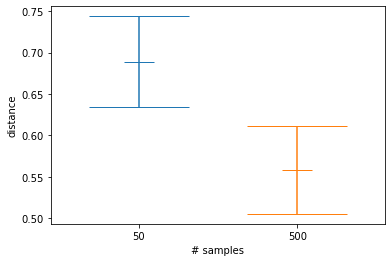

In [11]:
import matplotlib.pyplot as plt

distances = {r['num_samples']: [] for r in result_list}
for r in result_list:
    distances[r['num_samples']].append(r['distance'])
    
fig, ax = plt.subplots()
    
for i, (num_samples, dist) in enumerate(distances.items()):
    mean_dist = np.mean(dist)
    std_err = np.std(dist, ddof=1)/(len(dist)**(0.5))
    ax.errorbar(num_samples, mean_dist, yerr=std_err, marker='_', capsize=50, markersize=30)
    print(f'Num samples: {num_samples}, mean {mean_dist}, std. err. {std_err}')
    
ax.set_xlim(-200, 750)
ax.set_xticks(ticks=list(distances.keys()), labels=list(distances.keys()))
ax.set_ylabel('distance')
ax.set_xlabel('# samples')

We can also verify if all log-likelihoods are strictly non-decreasing. You should expect to see two points whose y-values are both 1 (i.e. True), indicating that the optimiser never decreased the log-likelihood.

Text(0.5, 0, '# samples')

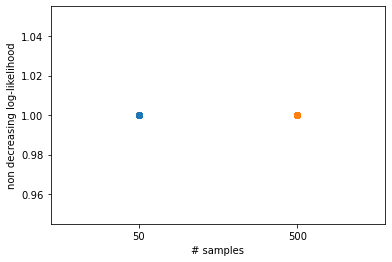

In [12]:
nondescs = {r['num_samples']: [] for r in result_list}
for r in result_list:
    nondescs[r['num_samples']].append(r['non_decreasing'])

fig, ax = plt.subplots()
    
for i, (num_samples, nondesc) in enumerate(nondescs.items()):
    ax.scatter([num_samples]*len(nondesc), nondesc)

ax.set_xlim(-200, 750)
ax.set_xticks(ticks=list(nondescs.keys()), labels=list(nondescs.keys()))
ax.set_ylabel('non decreasing log-likelihood')
ax.set_xlabel('# samples')